# k-means Clustering

## Table of contents

[1.) Simple k-means clustering example](#section_1)<br>
[2.) Image segmentation](#section_2)<br>
[3.) 3D point cloud segmentation](#section_3)<br>
[4.) Finding clusters in the apartment data](#section_4)

## Libraries and settings

In [239]:
# Install opencv-python-headless (neccessary in GitHub Codespaces)
!pip install --upgrade pip
!pip install opencv-python-headless

# Libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Current working directory
print('\nCurrent working directory:', os.getcwd())

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable

Current working directory: /workspaces/data_analytics/Week_10


## 1.) Simple k-means clustering example
<a id='section_1'></a>

### Create the dataset

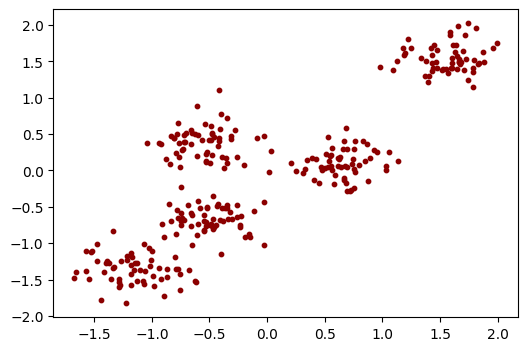

In [240]:
# Create data
centers = [[2,1], [-2,2], [-2,-2], [-4,-5], [5,7]]
X, y = make_blobs(n_samples=300, 
                  centers=centers, 
                  cluster_std=0.8,
                  random_state=42)

# Normalization of the values
X = StandardScaler().fit_transform(X)

# Plot the data
plt.figure(figsize=(6,4))
plt.scatter(X[:,0], X[:,1], s=10, color='darkred')
plt.show()

### Elbow Method showing the optimal k

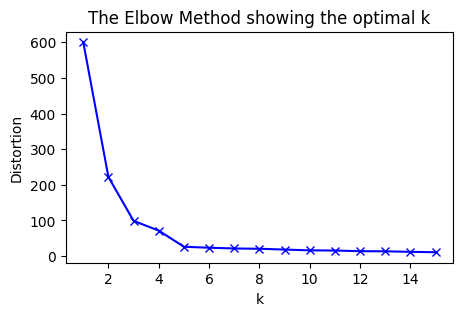

In [241]:
# Sum of squared distances of samples to their closest cluster center
distortions = []

# Range of k's
K = range(1,16,1)

# Loop to find the optimal k
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
    
# Elbow plot
plt.figure(figsize=(5,3))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

plt.show()

STATEMENT: Für den k-value kann 2 geeignet sein.

### Perform k-means clustering

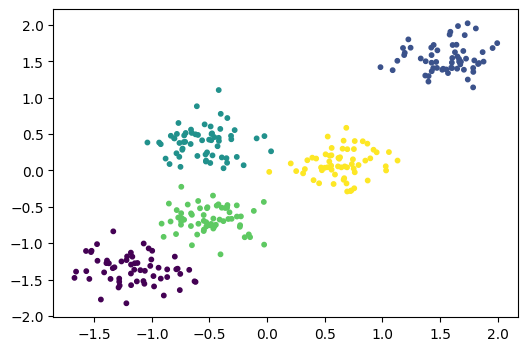

In [242]:
# Number of clusters
k = 5

# k-means clustering
kmeans = KMeans(n_clusters=k, random_state=42).fit(X)

# Predict the values
y2 = kmeans.predict(X)

# Plot the clusters
plt.figure(figsize=(6,4))
plt.scatter(X[:, 0], X[:, 1], c=y2, s=10)
plt.show()

### Get and check the converged cluster centroids

In [243]:
# Print centroids
centroids = kmeans.cluster_centers_
print('Cluster centroids:')
print(centroids, '\n')

# Check the 1st cluster's centroid 'by hand'
clust_00 = X[y2 == 0]
print('The 1st cluster\'s centroid:')
print(f'x = {sum(clust_00[:,0]/len(clust_00[:,0])):.8f}')
print(f'y = {sum(clust_00[:,1]/len(clust_00[:,1])):.8f}')

Cluster centroids:
[[-1.16214999 -1.36217282]
 [ 1.56276666  1.54186443]
 [-0.55467879  0.3889481 ]
 [-0.49867406 -0.67040574]
 [ 0.64167824  0.09023659]] 

The 1st cluster's centroid:
x = -1.16214999
y = -1.36217282


### Get the inertia or 'within-cluster sum-of-squares (WCSS)' of the k-means model

In [244]:
print(f'Within-cluster sum-of-squares: {kmeans.inertia_:.4f}')

Within-cluster sum-of-squares: 26.3487


### Perform Silhouette Analysis
- For examples see:
- https://laid-back-scientist.com/en/k-means
- https://machinelearninggeek.com/evaluating-clustering-methods
- https://medium.com/@favourphilic/how-to-interpret-silhouette-plot-for-k-means-clustering-414e144a17fe

k=2, Silhouette Score: 0.5325


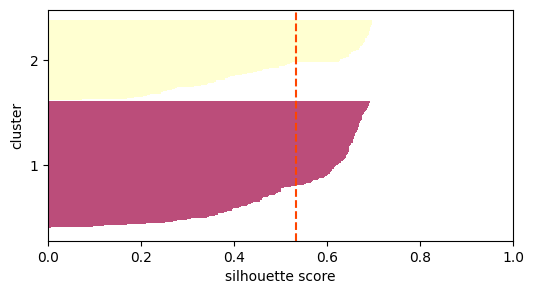

k=3, Silhouette Score: 0.5659


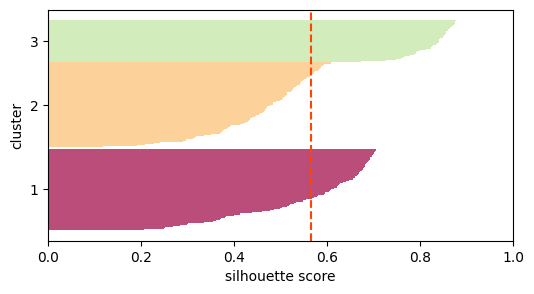

k=4, Silhouette Score: 0.6257


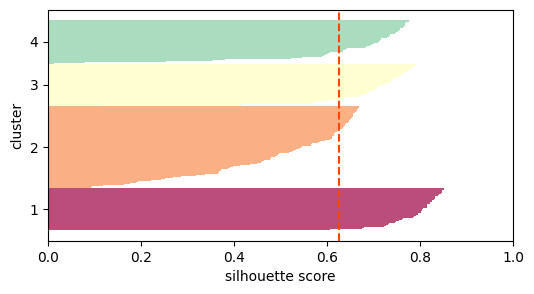

k=5, Silhouette Score: 0.6597


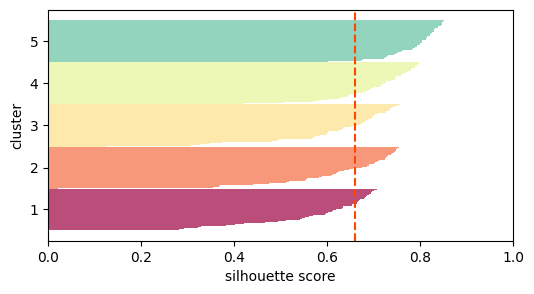

k=6, Silhouette Score: 0.6110


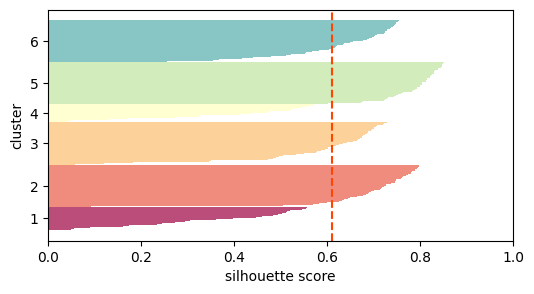

k=7, Silhouette Score: 0.5223


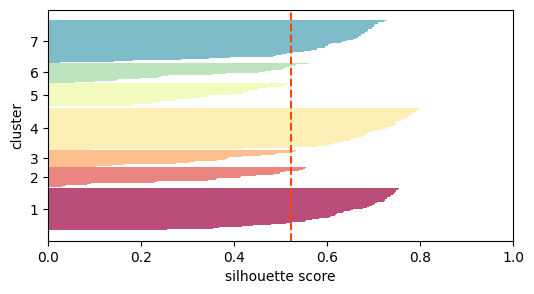

k=8, Silhouette Score: 0.4926


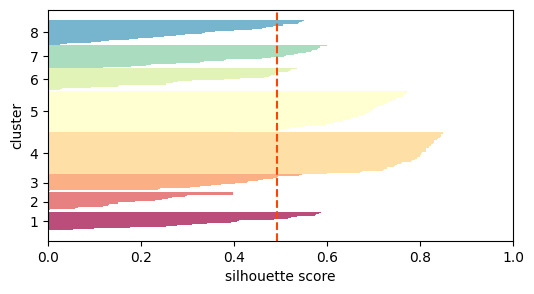

k=9, Silhouette Score: 0.4076


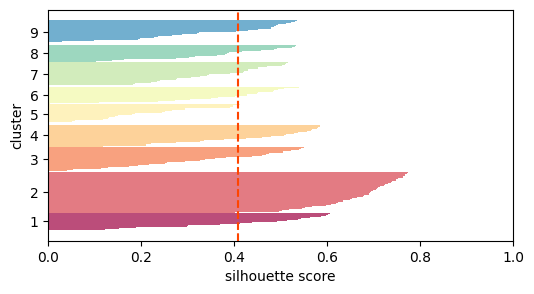

k=10, Silhouette Score: 0.4020


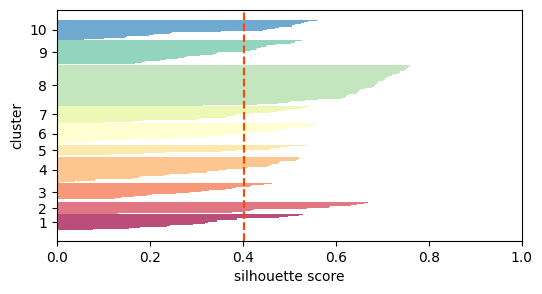

k=11, Silhouette Score: 0.3349


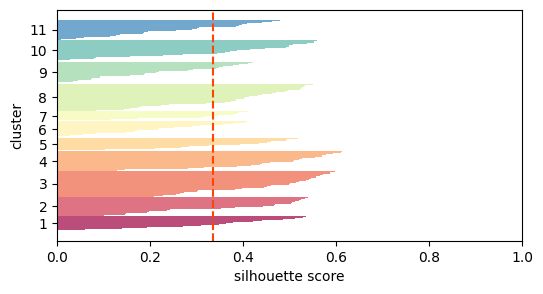

In [245]:
# Import own module for Silhouette plots
from silhouette import *

# Create Silhouette plots for different k's
# Note: range(2,12,1) provides: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
for i in range(2,12,1):
    model = KMeans(n_clusters=i, 
                   random_state=42, 
                   init='random')
    model.fit(X)
    print(f'k={i}, Silhouette Score: {silhouette_score(X, model.labels_):.4f}')
    plt.figure(figsize=(6,3))
    show_silhouette(X=X, fitted_model=model)

## 2.) Image segmentation
<a id='section_2'></a>

### Read the image

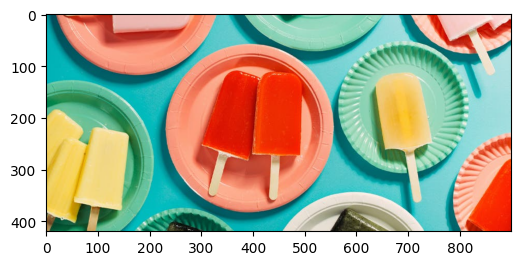

In [246]:
# Read the image
image = cv2.imread('icecream.jpg')
 
# Change the color to RGB (from BGR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the image
plt.figure(figsize=(6,8))
plt.imshow(image)

### Reshape the image

In [247]:
# Reshaping the image into a 2D array of pixels and RGB colors
pixel_vals = image.reshape((-1,3))
 
# Convert to float
pixel_vals = np.float32(pixel_vals)
pixel_vals

array([[  6., 161., 165.],
       [  2., 155., 160.],
       [  0., 147., 151.],
       ...,
       [214.,  17.,   1.],
       [211.,  15.,   0.],
       [207.,  14.,   0.]], dtype=float32)

### Elbow method showing the optimal k

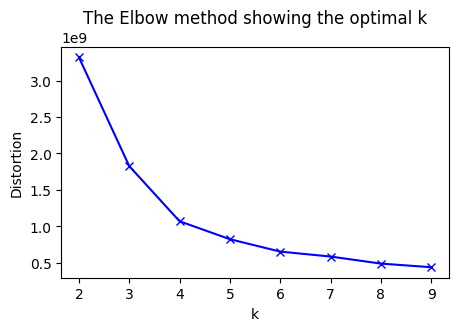

In [248]:
# Sum of squared distances of samples to their closest cluster center
distortions = []

# Range of k's
K = range(2,10,1)

# Loop to find the optimal k
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(pixel_vals)
    distortions.append(kmeanModel.inertia_)
    
# Elbow plot
plt.figure(figsize=(5,3))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow method showing the optimal k')

plt.show()

STATEMENT: Für den k-value wäre 3 geeignet

### Perform image segmentation

In [249]:
import cv2

# Number of clusters
k_values = [2, 3, 4, 5]

# Criteria for the segmentation algorithm to stop running
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)

# Perform k-means clustering for each k value
for k in k_values:
    retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Print cluster labels
    print(f'Cluster labels for {k} clusters:')
    print(labels, '\n')

    # Print cluster centroids
    print(f'Centroids of {k} clusters:')
    print(centers)
    print('-------------------------')


Cluster labels for 2 clusters:
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]] 

Centroids of 2 clusters:
[[ 77.73993 173.67543 159.0135 ]
 [234.49207 142.82184 101.63096]]
-------------------------
Cluster labels for 3 clusters:
[[0]
 [0]
 [0]
 ...
 [2]
 [2]
 [2]] 

Centroids of 3 clusters:
[[ 41.526783 152.27684  138.65152 ]
 [210.86714  194.775    158.86357 ]
 [221.65761   59.17975   25.890905]]
-------------------------
Cluster labels for 4 clusters:
[[0]
 [0]
 [0]
 ...
 [2]
 [2]
 [2]] 

Centroids of 4 clusters:
[[ 19.60903  133.21992  121.86354 ]
 [127.72386  207.31052  189.79639 ]
 [220.75728   53.97424   21.880688]
 [241.64398  182.72946  137.00546 ]]
-------------------------
Cluster labels for 5 clusters:
[[3]
 [3]
 [3]
 ...
 [2]
 [2]
 [2]] 

Centroids of 5 clusters:
[[242.07013  176.81898  127.200554]
 [164.15814  216.05974  200.12596 ]
 [220.90308   52.0016    20.26485 ]
 [ 55.16161  184.64883  172.29976 ]
 [ 20.85548  107.12405   91.33286 ]]
-------------------------


### Change data types and reshape the segmented data for visualization

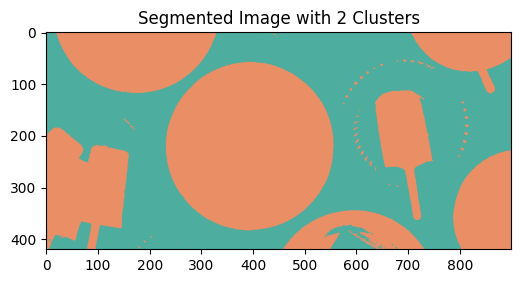

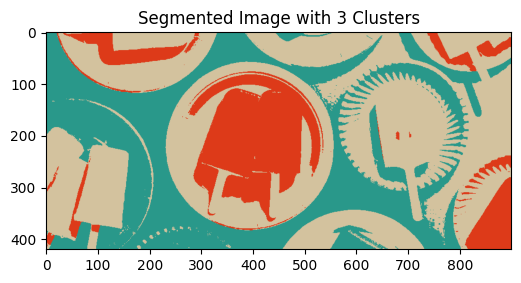

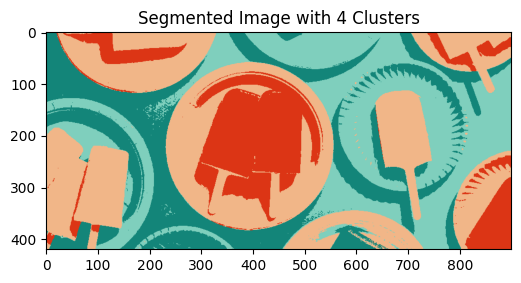

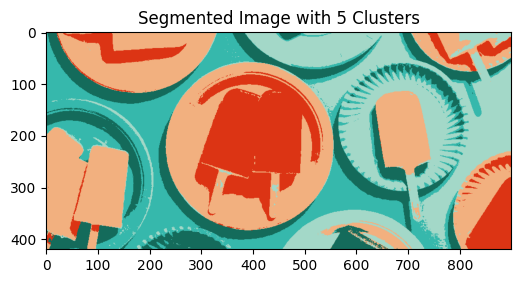

In [250]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Number of clusters
k_values = [2, 3, 4, 5]

# Criteria for the segmentation algorithm to stop running
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)

# Perform k-means clustering for each k value
for k in k_values:
    retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Convert centers to 8-bit values
    centers = np.uint8(centers)
    
    # Segment the data based on the cluster labels
    segmented_data = centers[labels.flatten()]
    
    # Reshape data into the original image dimensions
    segmented_image = segmented_data.reshape((image.shape))
    
    # Show result
    plt.figure(figsize=(6,8))
    plt.imshow(segmented_image)
    plt.title(f'Segmented Image with {k} Clusters')
    plt.show()


## 3.) 3D point cloud segmentation
- For details see: https://towardsdatascience.com/3d-point-cloud-clustering-tutorial-with-k-means-and-python-c870089f3af8
- Data-Viewer: https://app.flyvast.com/flyvast/app/page-snapshot-viewer.html#/444/9b557b91-8f41-16fa-cd2d-3476a1756611
<a id='section_3'></a>

### Import the data (Airport LIDAR point cloud dataset)

In [251]:
# Import the data
data = "KME_planes.xyz"
x, y, z, illuminance, reflectance, intensity, nb_of_returns = np.loadtxt(data,
                                                                         skiprows=1, 
                                                                         delimiter=';', 
                                                                         unpack=True)
# Array with positions of points
pcd = np.column_stack((x,y,z))

# Mean of z-variable (height above ground)
print(np.mean(z).round(4))

# Subset of the point cloud 
mask = (z > np.mean(z)) & (x <= 320) & (x >= 230)
spatial_query = pcd[mask]
spatial_query.shape

5.2829


(9676, 3)

### 3D plot of the point cloud subset

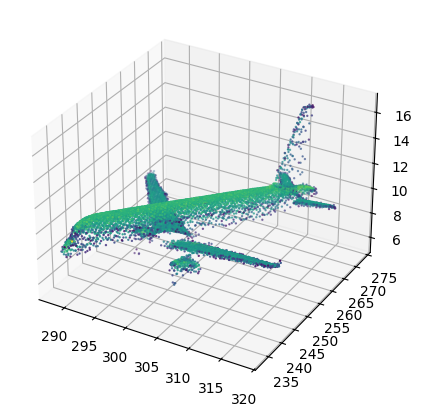

In [252]:
# 3D plot of the subset
plt.figure(figsize=(5,5))
ax = plt.axes(projection ='3d')
ax.scatter(x[mask], y[mask], z[mask], c=intensity[mask], s=0.5)
plt.show()

### 2D plot of the point cloud subset

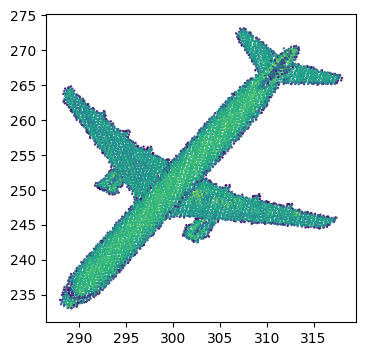

In [253]:
# 2D plot of the subset
plt.figure(figsize=(4,4))
plt.scatter(x[mask], y[mask], c=intensity[mask], s=0.5)
plt.show()

### Elbow method showing the optimal k

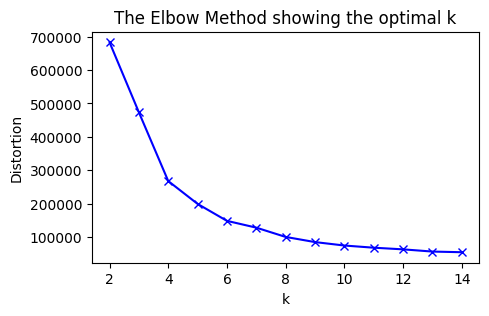

In [254]:
# Sum of squared distances of samples to their closest cluster center
distortions = []

# Range of k's
K = range(2,15,1)

# Loop to find the optimal k
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(spatial_query)
    distortions.append(kmeanModel.inertia_)
    
# Elbow plot
plt.figure(figsize=(5,3))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

plt.show()

### Point cloud segmentation based on k-means clustering

In [255]:
# Define number of clusters
k = 10

# Stack with x,y,z values
X2 = np.column_stack((x[mask], y[mask], z[mask]))

# Perform k-means clustering
kmeans_aerpl = KMeans(n_clusters=k, random_state=42).fit(X2)

STATEMENT: Die Segmentierung teilt das Flugzeug in verschiedenen Teilen gleichmässig auf.

### 2D plot of the segmented point cloud

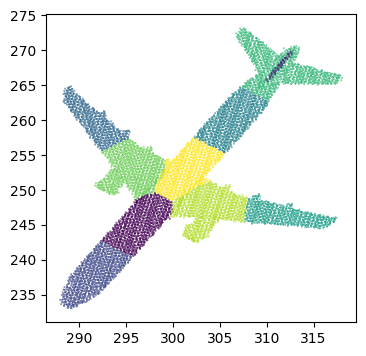

In [256]:
# 2D plot of image segmentation
plt.figure(figsize=(4,4))
plt.scatter(x[mask], y[mask], c=kmeans_aerpl.labels_, s = 0.1)
plt.show()

### 3D plot of the segmented point cloud

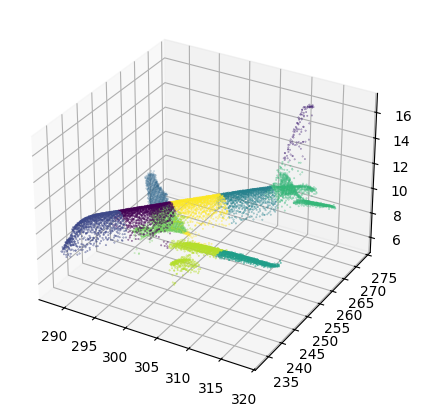

In [257]:
# 3D plot of image segmentation
plt.figure(figsize=(5,5))
ax = plt.axes(projection ='3d')
ax.scatter(x[mask], y[mask], z[mask], c=kmeans_aerpl.labels_, s=0.1)
plt.show()

### Calculate the Silhouette Score

In [258]:
print(f'Silhouette Score: {silhouette_score(X2, kmeans_aerpl.labels_):.4f}')

Silhouette Score: 0.4298


## 4.) Finding clusters in the apartment data
<a id='section_4'></a>

### Import the apartment data

In [259]:
# Define columns for import
columns = [ 'web-scraper-order',
            'address_raw',
            'rooms',
            'area',
            'luxurious',
            'price',
            'price_per_m2',
            'lat',
            'lon',
            'bfs_number',
            'bfs_name',
            'pop',
            'pop_dens',
            'frg_pct',
            'emp',
            'mean_taxable_income',
            'dist_supermarket']

# Read and select variables
df_orig = pd.read_csv("apartments_data_enriched_cleaned.csv", sep=";", encoding='utf-8')[columns]

# Rename variable 'web-scraper-order' to 'apmt_id'
df_orig = df_orig.rename(columns={'web-scraper-order': 'id'})

# Remove missing values
df = df_orig.dropna()
df.head(5)

# Remove duplicates
df = df.drop_duplicates()

# Remove some 'extreme' values
df = df.loc[(df['price'] >= 1000) & 
            (df['price'] <= 5000)]

print(df.shape)
df.head(5)

(722, 17)


,id,address_raw,rooms,area,luxurious,price,price_per_m2,lat,lon,bfs_number,bfs_name,pop,pop_dens,frg_pct,emp,mean_taxable_income,dist_supermarket
0,1693998201-1,"Neuhusstrasse 6, 8630 Rüti ZH, ZH",3.0,49,0,1441,29.41,47.252171,8.845797,118,Rüti (ZH),12286,1221.272366,24.841283,5053,65362.04268,645.652248
1,1693998233-172,"Widacherstrasse 5, 8630 Rüti ZH, ZH",3.0,111,0,2600,23.42,47.252087,8.854919,118,Rüti (ZH),12286,1221.272366,24.841283,5053,65362.04268,265.102153
2,1693998256-331,"Widenweg 14, 8630 Rüti ZH, ZH",3.0,58,0,1490,25.69,47.253670,8.853993,118,Rüti (ZH),12286,1221.272366,24.841283,5053,65362.04268,94.401821
3,1693998265-381,"Rain 1, 8630 Rüti ZH, ZH",4.0,118,0,3240,27.46,47.259834,8.851705,118,Rüti (ZH),12286,1221.272366,24.841283,5053,65362.04268,106.660970
4,1693998276-419,"Bachtelstrasse 24b, 8630 Rüti ZH, ZH",3.0,66,0,1450,21.97,47.266113,8.866872,118,Rüti (ZH),12286,1221.272366,24.841283,5053,65362.04268,974.844209


### Subset of the apartment data frame for k-means clustering

In [260]:
# Define a subset of the data frame for k-means clustering
X3 = df[['rooms',
         'area',
         'price_per_m2',
         'price',
         'dist_supermarket',]]

### Elbow method showing the optimal k

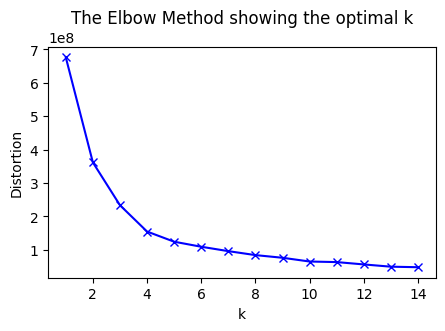

In [261]:
# Sum of squared distances of samples to their closest cluster center
distortions = []

# Range of k's
K = range(1,15)

# Loop to find the optimal k
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X3)
    distortions.append(kmeanModel.inertia_)
    
# Elbow plot
plt.figure(figsize=(5,3))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

plt.show()

### Perform k-means clustering on the apartment data

In [262]:
# Number of clusters
k = 3

# Perform k-means clustering
kmeans_apmts = KMeans(n_clusters=k, random_state=42).fit(X3)

# Add the clusters to data frame
X3['cluster'] = kmeans_apmts.predict(X3)

# Show number of apartments per cluster
X3['cluster'].value_counts().sort_values(ascending=False)


print(kmeans_apmts.labels_, '\n')   
print(kmeans_apmts.inertia_, '\n')  
print(kmeans_apmts.cluster_centers_, '\n')  
print(kmeans_apmts.feature_names_in_)

[1 2 1 0 1 1 1 2 1 0 0 2 0 0 1 1 2 2 1 1 2 2 2 1 2 2 0 0 0 1 0 0 2 2 1 0 0
 0 1 2 2 0 2 0 0 1 1 2 2 0 0 1 0 0 1 1 0 2 0 0 2 0 2 2 2 0 2 0 2 2 1 2 1 0
 2 1 1 2 0 2 2 0 2 2 0 0 2 2 2 2 1 2 1 1 1 1 0 0 2 2 2 2 0 2 0 0 2 2 2 2 2
 2 2 2 0 2 0 1 0 0 0 2 1 1 2 2 1 1 2 1 0 1 1 2 2 2 2 0 2 2 0 0 0 2 0 1 0 0
 2 2 2 2 0 1 2 0 1 1 0 1 1 2 1 1 2 1 1 1 1 2 2 1 0 2 1 0 0 2 1 1 2 2 0 0 1
 0 0 0 2 1 2 2 1 1 1 1 0 1 1 1 1 1 0 2 1 1 2 2 0 2 0 2 0 2 0 1 0 0 2 1 2 0
 2 2 0 2 0 2 2 2 0 0 1 1 0 2 1 1 2 1 2 0 1 1 1 2 2 2 0 0 2 2 1 2 0 2 1 2 1
 1 1 1 0 2 1 2 0 0 1 2 0 1 0 2 2 0 1 2 0 2 2 0 1 1 1 1 1 2 2 1 2 2 2 1 1 1
 2 1 1 1 1 2 2 1 1 2 2 1 1 2 1 1 1 2 1 2 2 1 1 1 2 2 1 2 2 1 2 1 1 1 1 1 1
 1 1 2 1 2 1 2 1 2 2 2 1 1 1 2 2 2 1 0 1 1 1 1 2 0 2 1 2 1 1 1 2 1 1 1 1 0
 1 1 1 2 1 2 1 1 2 1 2 0 2 1 1 1 1 2 1 2 1 2 1 1 1 1 1 1 0 1 2 1 2 1 2 2 1
 1 1 1 2 1 2 0 0 0 1 2 1 1 1 2 2 2 2 1 2 2 1 1 0 1 1 1 2 1 0 1 1 1 1 0 1 1
 2 2 1 2 0 1 1 0 2 1 0 1 1 1 1 1 1 2 1 1 0 2 0 1 1 1 1 2 2 2 2 0 1 1 2 1 1
 1 2 2 1 2 1 1 1 2 2 1 2 

EXPLAINATION:
1. **labels_ndarray**: Clusterzuweisung für jeden Datenpunkt.
2. **inertia_float**: Summe der quadrierten Abstände zu den Clusterzentren.
3. **cluster_centers_ndarray**: Koordinaten der Clusterzentren.
4. **feature_names_in_ndarray**: Namen der während des Trainings verwendeten Merkmale.

### Plot the apartment clusters

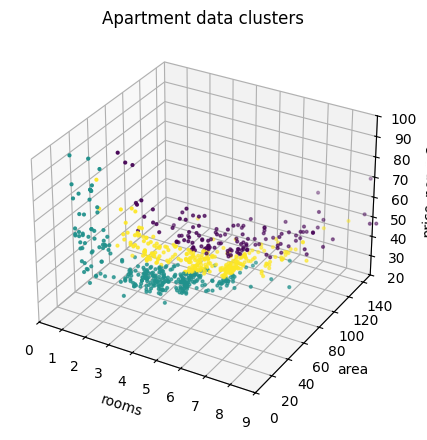

In [263]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['rooms'], df['area'], df['price_per_m2'], c=kmeans_apmts.labels_, s=4)

# Set title and axes labels
ax.set_title('Apartment data clusters', fontsize=12)
ax.set_xlabel('rooms', fontsize=10)
ax.set_ylabel('area', fontsize=10)
ax.set_zlabel('price_per_m2', fontsize=10)

# Set axes range
ax.set_xlim([0,9])
ax.set_ylim([0,150])
ax.set_zlim([20,100])

plt.show()

### Calculate the Silhouette Score

In [264]:
print(f'Silhouette Score: {silhouette_score(X3, kmeans_apmts.labels_):.4f}')

Silhouette Score: 0.3685


STATEMENT: Den k-value Wert 3 vom elbow Method ist nicht geeignet, da es nahe zu 0 ist und somit eine schlechte Zuordnung ist.

### Jupyter notebook --footer info-- (please always provide this at the end of each submitted notebook)

In [265]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.5.0-1025-azure
Datetime: 2024-11-22 09:25:22
Python Version: 3.11.10
-----------------------------------
